In [186]:
# Data processing
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model

# Removing seaborn plotting warnings
import warnings
warnings.filterwarnings('ignore')

# Uploading files
import os

In [187]:
# Upload all required datasets
import pandas as pd
rating = pd.read_csv('tourism_rating.csv')
place = pd.read_csv('tourism_with_id.csv')
user = pd.read_csv('user.csv')

In [188]:
def column_encoder(column, data=encoded_df):
  unique_values = data[column].unique().tolist()
  value_to_encoded = {x: i for i, x in enumerate(unique_values)}
  encoded_to_value = {i: x for i, x in enumerate(unique_values)}
  return value_to_encoded, encoded_to_value

In [189]:
# Dropping unused columns in place dataset
place = place.drop(['Unnamed: 11', 'Unnamed: 12', 'Time_Minutes'], axis=1)
place.head()

# Encoding Place_Id
place_to_encoded, encoded_to_place = column_encoder('Place_Id')

# Mapping Place_Id to the dataframe
rating['place'] = rating['Place_Id'].map(place_to_encoded)

In [190]:
# Filtering rating data to only contain rating for places in Bandung
rating = pd.merge(rating, places[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings,place
0,36,1,4,0
1,38,1,2,0
2,64,1,2,0
3,74,1,2,0
4,86,1,4,0


In [191]:
# Filtering user data to only contain user who visited places in Bandung
user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')

# Encoding User_Id
user_to_encoded, encoded_to_user = column_encoder('User_Id')

# Mapping User_Id to the dataframe
rating['user'] = rating['User_Id'].map(user_to_encoded)

In [192]:
encoded_df = rating.copy()
encoded_df.head()

,User_Id,Place_Id,Place_Ratings,place,user
0,36,1,4,0,0
1,38,1,2,0,1
2,64,1,2,0,2
3,74,1,2,0,3
4,86,1,4,0,4


In [193]:
# Getting the number of users and places
num_users, num_places = len(user_to_encoded), len(place_to_encoded)

# Converting rating to float values
rating['Place_Ratings'] = rating['Place_Ratings'].values.astype(np.float32)

# Getting the minimum and maximum rating values
min_rating, max_rating = min(rating['Place_Ratings']), max(rating['Place_Ratings'])

print(f'Number of Users: {num_users}, Number of Places: {num_places}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of Users: 300, Number of Places: 437, Min Rating: 1.0, Max Rating: 5.0


In [194]:
# Shuffling the dataset
rating = rating.sample(frac=1, random_state=42)
rating.head()

,User_Id,Place_Id,Place_Ratings,place,user
6252,203,274,2.0,273,36
4684,126,206,5.0,205,112
1731,7,77,5.0,76,169
4742,198,208,5.0,207,166
4521,280,199,5.0,198,51


In [195]:
# Combining user and place data into a single input variable
x = rating[['user', 'place']].values

# Scaling the rating to a range of 0 to 1
y = rating['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Splitting the data into 80% train and 20% validation
train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [196]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.places_embedding = layers.Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.places_bias = layers.Embedding(num_places, 1) # layer embedding places bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # memanggil layer embedding 3
    places_bias = self.places_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_places = tf.tensordot(user_vector, places_vector, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [197]:
# Create an instance of your custom model
model = RecommenderNet(num_users, num_places, 50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [198]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_root_mean_squared_error') < 0.25:
            print('Congratulations! Validation metrics meet the expectation.')
            self.model.stop_training = True

In [199]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[MyCallback()]
)

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.6999 - root_mean_squared_error: 0.3503 - val_loss: 0.7022 - val_root_mean_squared_error: 0.3506
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6980 - root_mean_squared_error: 0.3489 - val_loss: 0.7020 - val_root_mean_squared_error: 0.3505
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6972 - root_mean_squared_error: 0.3484 - val_loss: 0.7018 - val_root_mean_squared_error: 0.3503
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6949 - root_mean_squared_error: 0.3467 - val_loss: 0.7011 - val_root_mean_squared_error: 0.3499
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6932 - root_mean_squared_error: 0.3455 - val_loss: 0.7006 - val_root_mean_squared_error: 0.3496
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6928 - root_mean_squared_error: 0.3452 - val_loss: 0.7007 

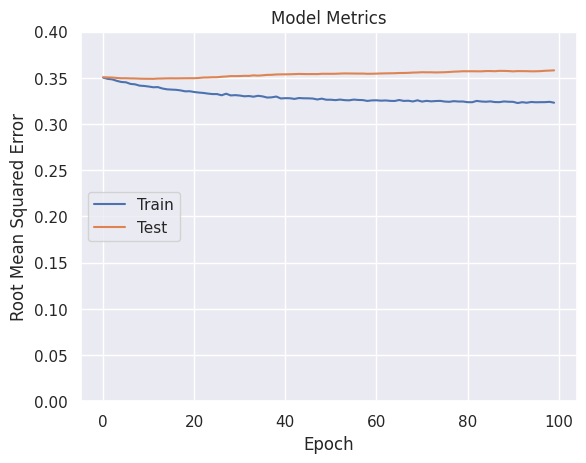

In [200]:
# Plotting the loss and validation metrics
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['Train', 'Test'], loc='center left')
plt.show()

In [201]:
# Saving the Model as .pb (Protocol Buffer) format
model.save('destinasi_wisata_model', save_format='tf')

In [202]:
# Saving the Model Weights as .h5 file
model.save_weights('wisata_model.h5')

In [203]:
# Saving the Model as .pkl (Pickle) file
import joblib
joblib.dump(model, 'wisata_model.pkl')

['wisata_model.pkl']

In [204]:
# Serializing the Model to JSON
model_json = model.to_json()
with open("wisata_model.json", "w") as json_file:
    json_file.write(model_json)

In [212]:
# Saving DataFrame to CSV
df.to_csv('destinasi_wisata.csv', index=False)
place.to_csv('data_wisata.csv', index=False)

In [206]:
# Loading the Model from .h5 file
model.load_weights("wisata_model.h5")
print("Model .h5 Successfully Loaded")

Model .h5 Successfully Loaded


In [207]:
# Loading the Model from .pkl file
model = joblib.load('wisata_model.pkl')
print("Model .pkl Successfully Loaded")

Model .pkl Successfully Loaded


In [208]:
# Preparing the dataframe
place_df = place[['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price']]
place_df.columns = ['id', 'place_name', 'category', 'rating', 'price']
df = rating.copy()

In [209]:
# Selecting a random user
user_id = df.User_Id.sample(1).iloc[0]
places_visited_by_user = df[df.User_Id == user_id]

In [210]:
# Creating data for places not visited by the user
places_not_visited = place_df[~place_df['id'].isin(places_visited_by_user.Place_Id.values)]['id']
places_not_visited = list(
    set(places_not_visited)
    .intersection(set(place_to_encoded.keys()))
)

places_not_visited = [[place_to_encoded.get(x)] for x in places_not_visited]
user_encoder = user_to_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(places_not_visited), places_not_visited)
)

In [211]:
# Getting top 7 recommendations
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-7:][::-1]
recommended_place_ids = [
    encoded_to_place.get(places_not_visited[x][0]) for x in top_ratings_indices
]

print('Recommendations for: {}'.format('User ' + str(user_id)))
print('===' * 15, '\n')
print('----' * 15)
print('Places with the highest ratings from the user')
print('----' * 15)

top_places_user = (
    places_visited_by_user.sort_values(
        by='Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

place_df_rows = place_df[place_df['id'].isin(top_places_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendations')
print('----' * 15)

recommended_places = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_places.itertuples(), range(1, 8)):
    print(i, '.', row.place_name, '\n    ', row.category, ',', 'Ticket Price ', row.price, ',', 'Rating ', row.rating, '\n')

print('===' * 15)

13/13 [==============================] - 0s 2ms/step
Recommendations for: User 225

------------------------------------------------------------
Places with the highest ratings from the user
------------------------------------------------------------
Taman Menteng : Taman Hiburan
Taman Badak : Taman Hiburan
Curug Cimahi : Cagar Alam
Jembatan Biru Ambarawa : Taman Hiburan
Food Junction Grand Pakuwon : Pusat Perbelanjaan

------------------------------------------------------------
Top 7 place recommendations
------------------------------------------------------------
1 . Monumen Nasional 
     Budaya , Ticket Price  20000 , Rating  4.6 

2 . Kampung Cina 
     Budaya , Ticket Price  15000 , Rating  4.5 

3 . Puncak Gunung Api Purba - Nglanggeran 
     Cagar Alam , Ticket Price  10000 , Rating  4.7 

4 . Pantai Baron 
     Bahari , Ticket Price  10000 , Rating  4.4 

5 . Stone Garden Citatah 
     Taman Hiburan , Ticket Price  30000 , Rating  4.4 

6 . Bukit Jamur 
     Cagar Alam , Ti